# Step One: Set up your analysis and Jupyter Notebook

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
from datetime import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from IPython.display import Image, display
mpl.rc('figure', max_open_warning = 0)
teamdf = pd.read_csv('Teams.csv') # yearly stats and standings...data pre-1990 may not be accurate...
                                 # only looking at >1989 for analysis
cities = pd.read_csv('targetcities.csv') # city data
payrolls = pd.read_csv('payrolls.csv') # team payrolls on opening day of that year
temps = pd.read_csv('temps.csv') # city temperature data during the baseball season

# Data Cleansing

In [2]:
# drop columns we are not interested in
teamdf.drop(['lgID','divID','Ghome','AB','SF','IPouts','BPF','PPF','teamIDBR','teamIDlahman45',
           'teamIDretro','G','R','H','2B','3B','HR','BB','SO','SB','CS','HBP','RA','ER','ERA','CG','SHO',
         'SV','HA','HRA','BBA','SOA','E','DP','FP','DivWin','WCWin','LgWin','WSWin','name','park',
          '2ndteam'], inplace=True, axis=1)

In [3]:
teamdf = teamdf[teamdf['yearID'] >= 1990] # filtering years we want
teamdf['yearID'] = teamdf['yearID'].astype(int) # convert columns to correct type
teamdf['Rank'] = teamdf['Rank'].astype(int)
teamdf['W'] = teamdf['W'].astype(int)
teamdf['L'] = teamdf['L'].astype(int)
teamdf['attendance'] = teamdf['attendance'].astype(int)
teamdf['in_city_since'] = teamdf['in_city_since'].astype(int)
teamdf['years_in_city'] = teamdf['years_in_city'].astype(int)

payrolls['yearID'] = payrolls['yearID'].astype(int)
payrolls['payroll'] = payrolls['payroll'].astype(int)
payrolls['teamID'] = payrolls['teamID'].astype(str)

In [4]:
mergedf =  pd.merge(teamdf, cities, on="City", how='inner') # merge city data with our main dataframe
mergedf = mergedf.merge(payrolls, how='inner', left_on=["teamID", "yearID"], right_on=["teamID","yearID"]) #team payrolls too
mergedf = pd.merge(mergedf, temps, on="City", how='inner') # bring in weather data
mergedf.drop(['State_y','State_x'], inplace = True, axis=1) # drop duplicated columns that were added durng merges

### The data looks pretty good so far, there might be some nulls to fill in later for a few variables.

In [5]:
mergedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 0 to 877
Data columns (total 29 columns):
yearID             878 non-null int32
teamID             878 non-null object
franchID           878 non-null object
Rank               878 non-null int32
W                  878 non-null int32
L                  878 non-null int32
attendance         878 non-null int32
City               878 non-null object
parkscore          825 non-null float64
nativerate         819 non-null float64
in_city_since      878 non-null int32
years_in_city      878 non-null int32
pop                878 non-null int64
citygdp            878 non-null int64
big4teams          878 non-null int64
income             878 non-null int64
medianage          878 non-null int64
milestonextpark    878 non-null int64
Bapop              878 non-null object
Barate             878 non-null float64
payroll            878 non-null int32
Apr                878 non-null float64
May                878 non-null float64
Jun    

### Now that most of our data is merged to one dataframe, let's check it out. Let's start with attendance since that will be our focus throughout the project.

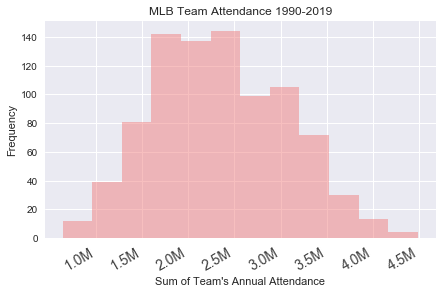

In [6]:
plt.style.use('seaborn')
f, ax1 = plt.subplots(figsize=(7,4))
x = mergedf['attendance']
num_bins = 12
plt.hist(x, num_bins, facecolor='lightcoral', alpha=.5)
ax1.set(title='MLB Team Attendance 1990-2019', ylabel='Frequency', xlabel="Sum of Team's Annual Attendance")
ax1.set_xticks([1000000, 1500000, 2000000, 2500000,3000000,3500000,4000000,4500000])
ax1.set_xticklabels(labels=['1.0M', '1.5M', '2.0M', '2.5M', '3.0M', '3.5M','4.0M','4.5M'], fontsize=14, color='#414141')
plt.xticks(rotation=30)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
plt.show()

### Overall the distribution is fairly normal. There are many more seasons that had teams with 1.5 million to 2.5 million tickets sold than seasons not in that range. Let's look at the descriptive stats too.

In [7]:
mergedf['attendance'].describe()

count    8.780000e+02
mean     2.350920e+06
std      7.177583e+05
min      6.427450e+05
25%      1.787307e+06
50%      2.306085e+06
75%      2.903518e+06
max      4.483350e+06
Name: attendance, dtype: float64

### The mean and median, which is shown as the 50th percentile above, are very close which is another indicator that our distribution is overall normal. This justifies using Pearson's correlation coefficient later on.

### The range for attendance is quite wide. There are some teams that had over 4 million tickets sold in a season, and other teams that sold less than 1 million. Are there any teams that seem to always have below average attendance figures?

In [8]:
mergedf.teamID.unique() # populate list of all teamIDs to use for a visualization loop

array(['ATL', 'BAL', 'BOS', 'LAA', 'LAD', 'CHA', 'CHN', 'CIN', 'CLE',
       'DET', 'HOU', 'KCR', 'MIN', 'MIL', 'MON', 'NYY', 'NYM', 'OAK',
       'SFG', 'PHI', 'PIT', 'SDP', 'SEA', 'STL', 'TEX', 'TOR', 'COL',
       'MIA', 'ARI', 'TBA', 'WAS'], dtype=object)

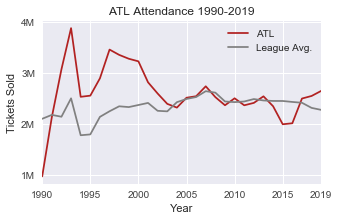

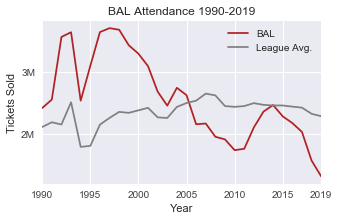

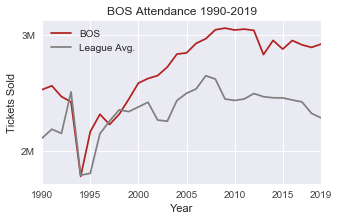

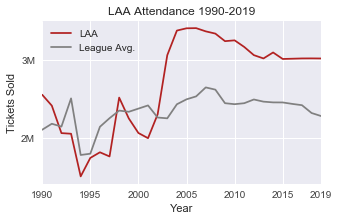

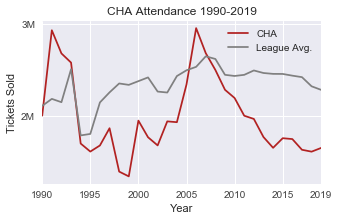

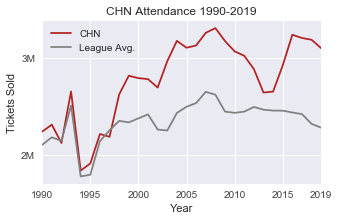

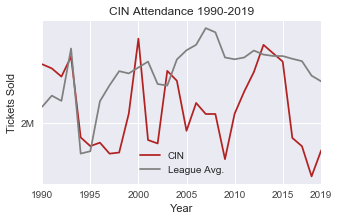

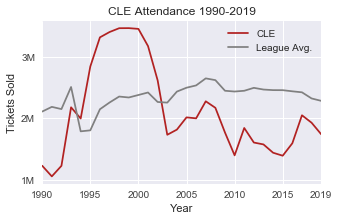

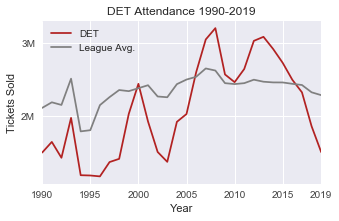

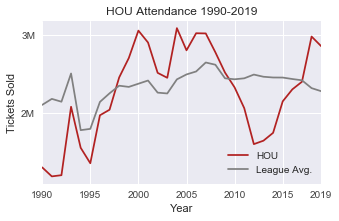

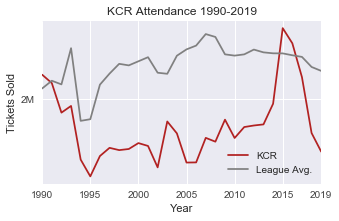

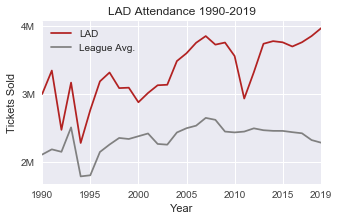

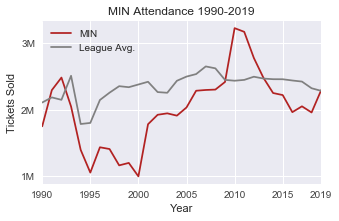

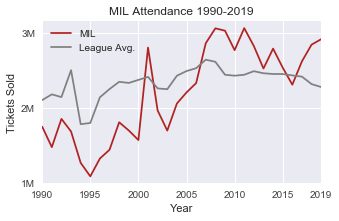

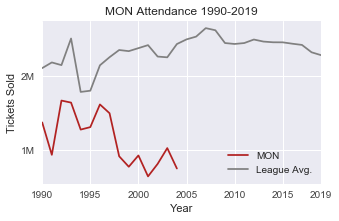

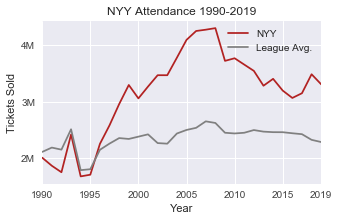

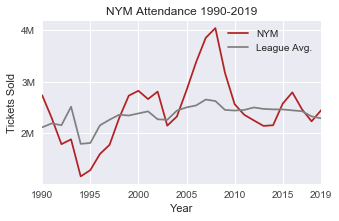

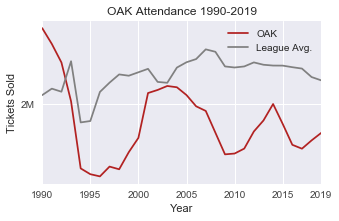

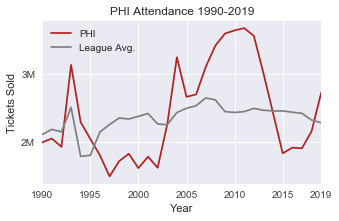

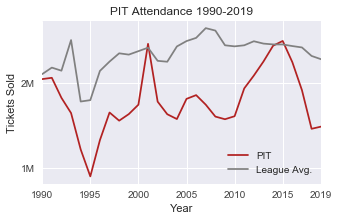

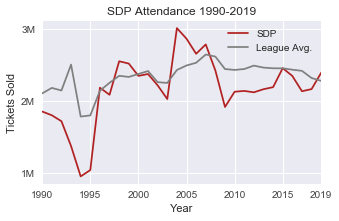

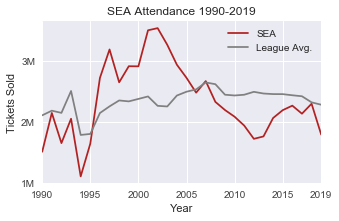

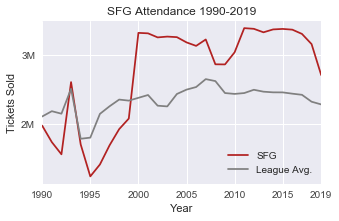

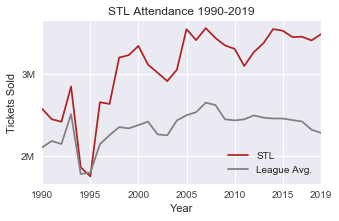

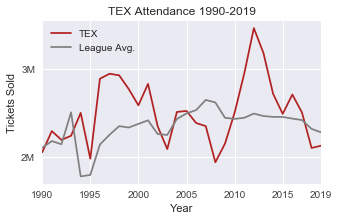

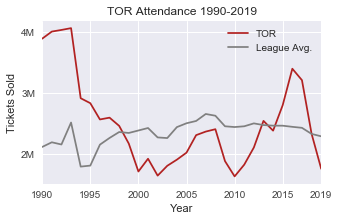

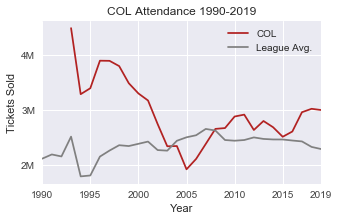

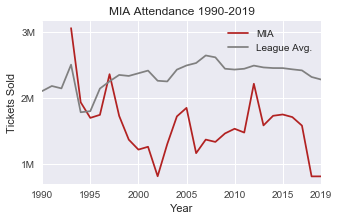

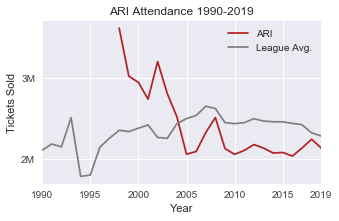

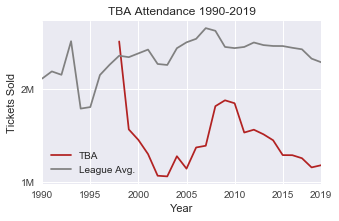

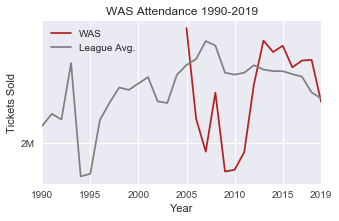

In [9]:
# Create a list of all franchID's that had seasons from 1990-2019
teamlist = ['ATL', 'BAL', 'BOS', 'LAA', 'CHA', 'CHN', 'CIN', 'CLE', 'DET',
       'HOU', 'KCR', 'LAD', 'MIN', 'MIL', 'MON', 'NYY', 'NYM', 'OAK',
       'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TEX', 'TOR', 'COL',
       'MIA', 'ARI', 'TBA', 'WAS']
#Let's look at each team's attendance compared to the league average to see if any team's stick out.
#Create a loop that will plot every team's attendance vs. the league average in a seperate chart. 
for i in teamlist: 
    data = teamdf[teamdf['teamID'] == i]
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1 = data.groupby('yearID').attendance.sum().plot(kind='line',label=i, color='firebrick')
    ax1.set_yticks([0, 1000000, 2000000, 3000000, 4000000])
    ax1.set_yticklabels(labels=['0', '1M', '2M', '3M', '4M'], fontsize=10, color='#414141')
    ax1.set_xticks([1990, 1995, 2000, 2005, 2010, 2015, 2019])
    ax1.set_xticklabels(labels=['1990', '1995', '2000', '2005', '2010','2015','2019'], fontsize=10, color='#414141')
    mean = teamdf.groupby('yearID').attendance.mean().plot(kind='line',color='gray',label='League Avg.')
    ax1.set(title=i + ' Attendance 1990-2019', ylabel='Tickets Sold', xlabel='Year')
    ax1.legend(loc='best')

### Some ballclubs stand out for consistently poor attendance. Montreal (MON) had very low attendance compared to the average and actually relocated to Washington, DC, which is shown as their line stopping about halfway in on their chart. Since that franchise's relocation, attendance has been been inconsistent, but overall much better than it was in Montreal.

### Tampa Bay (TBA) has had very low attendance aside from their inaugural season. Miami (MIA) has also had below average attendance since at least 1998. These two clubs are the only MLB teams in Florida. Maybe there is something about Florida's demographics or market that makes it difficult for baseball teams to bring fans to the games. 

### Oakland (OAK) has had below average attendance every year since at least 1995. Oakland's ballpark is consistently ranked as one of the worst in baseball for fans. They also have another MLB team, the San Francisco Giants (SFG), only a few miles away. The Giants have had significantly above average attendance years since 2000. Maybe they are pulling fans away from Oakland. 

C:\Users\cochr\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\cochr\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


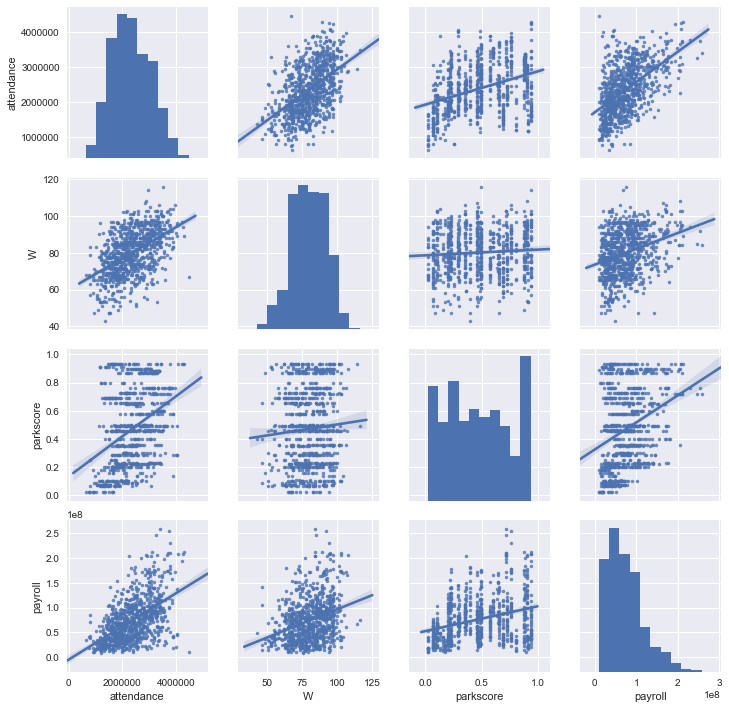

In [10]:
pp1 = ['attendance','W','parkscore','payroll']
sns.pairplot(mergedf[pp1],kind='reg',markers=".")
plt.show()

### Above we look at best-fit regression lines between variables and how each variable is distributed via histograms. In regards to our target variable, attendance, W (wins), payroll, and parkscore look to be positively correlated.

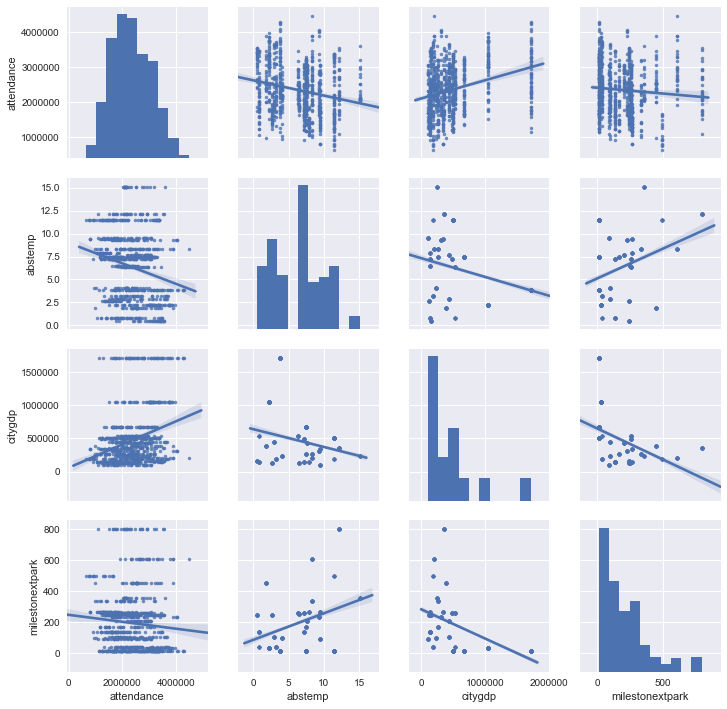

In [11]:
pp2 = ['attendance','abstemp','citygdp','milestonextpark']
sns.pairplot(mergedf[pp2],kind='reg',markers=".")
plt.show()

### More variables correlating with attendance above. Now let's look at all variables with correlation heatmaps.

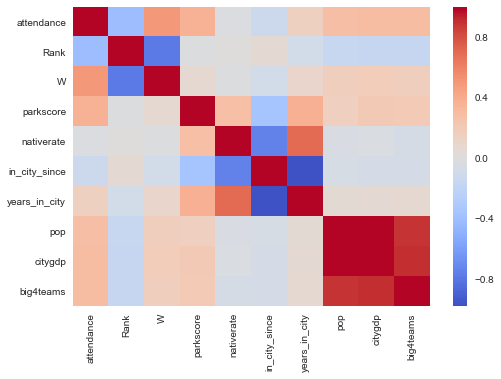

In [12]:
col1 = ['attendance','Rank','W','parkscore','nativerate','in_city_since','years_in_city',
                 'pop','citygdp','big4teams']
heatmap1 = mergedf[col1].corr()
ax1 = sns.heatmap(heatmap1, center=0, cmap="coolwarm")
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5) #fixes matplotlib bug that only shows top half and bottom half of top and bottom rows
plt.show()

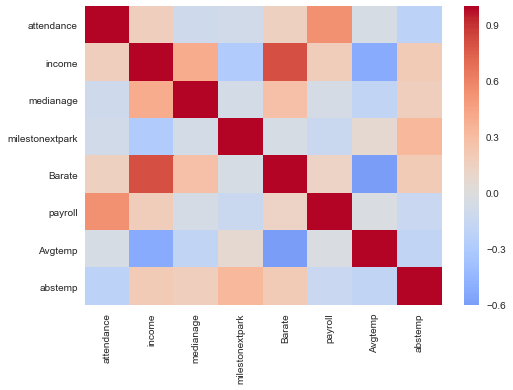

In [13]:
col2 = ['attendance','income','medianage','milestonextpark','Bapop','Barate','payroll',
                 'Avgtemp','abstemp']
heatmap2 = mergedf[col2].corr()
ax1 = sns.heatmap(heatmap2, center=0, cmap="coolwarm")
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### These heatmaps indicate pearson correlation coefficients for each variable. The darker the color, the stronger the correlation (red is positive and blue is negative). Wins, Rank, parkscore,  payroll, abstemp look to have the strongest correlations with attendance. 

### 'Abstemp' is defined as the absolute value of a city's average temperature from April-September (baseball season) minus 70 degrees. This gives us a rough idea of how "nice" a city's weather is during baseball season. 

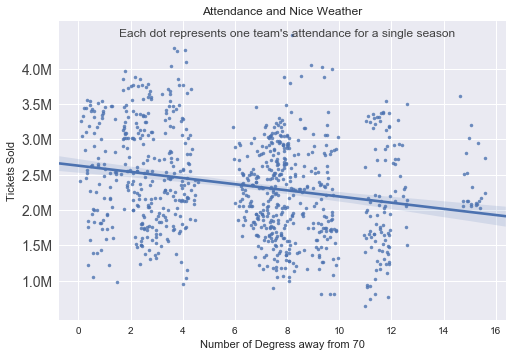

In [14]:
plt.style.use('seaborn')
x = mergedf['abstemp']
y = mergedf['attendance']

ax1=sns.regplot(x,y,data=mergedf,x_jitter=.5,marker=".")
ax1.set(title='Attendance and Nice Weather', ylabel='Tickets Sold', xlabel="Number of Degress away from 70")
ax1.set_yticks([1000000, 1500000, 2000000, 2500000,3000000,3500000,4000000])
ax1.set_yticklabels(labels=['1.0M', '1.5M', '2.0M', '2.5M', '3.0M', '3.5M','4.0M'], fontsize=14, color='#414141')
ax1.text(x=8, y=4500000, s="Each dot represents one team's attendance for a single season", fontsize=12, horizontalalignment='center', verticalalignment = 'center',color='#414141')
plt.show()

### Taking a look at the 'abstemp' variable, we see that as farther a city's temperature* deviates from 70 degrees F, the lower their MLB team's attendance is. 

##### *A city's temperature is the mean temp during baseball season (April-September)

### Let's look how winning (W) and attendance look together plotted.

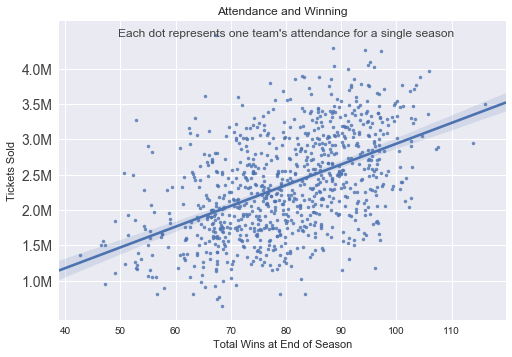

In [15]:
x = mergedf['W']
y = mergedf['attendance']

ax1=sns.regplot(x,y,data=mergedf,x_jitter=.5,marker=".")
ax1.set(title='Attendance and Winning', ylabel='Tickets Sold', xlabel="Total Wins at End of Season")
ax1.set_yticks([1000000, 1500000, 2000000, 2500000,3000000,3500000,4000000])
ax1.set_yticklabels(labels=['1.0M', '1.5M', '2.0M', '2.5M', '3.0M', '3.5M','4.0M'], fontsize=14, color='#414141')
ax1.text(x=80, y=4500000, s="Each dot represents one team's attendance for a single season", fontsize=12, horizontalalignment='center', verticalalignment = 'center',color='#414141')
plt.show()

### As expected, more fans attend games while a team is winning. What about if we look at previous seasons win totals? 'rollingwins' will be the average win total of the last three seasons. 

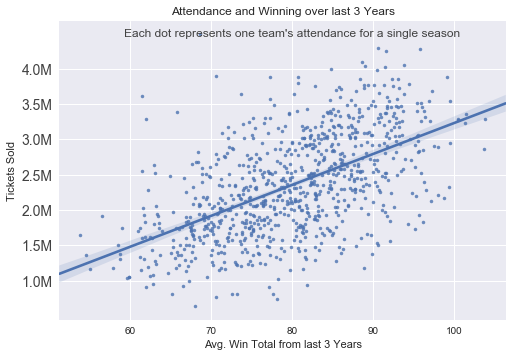

In [16]:
mergedf['rollingwins'] = mergedf['W'].rolling(3).mean()
x = mergedf['rollingwins'] # population of metro area where MLB team is based 
y = mergedf['attendance']

ax1=sns.regplot(x,y,data=mergedf,x_jitter=.5,marker=".")
ax1.set(title='Attendance and Winning over last 3 Years', ylabel='Tickets Sold', xlabel="Avg. Win Total from last 3 Years")
ax1.set_yticks([1000000, 1500000, 2000000, 2500000,3000000,3500000,4000000])
ax1.set_yticklabels(labels=['1.0M', '1.5M', '2.0M', '2.5M', '3.0M', '3.5M','4.0M'], fontsize=14, color='#414141')
ax1.text(x=80, y=4500000, s="Each dot represents one team's attendance for a single season", fontsize=12, horizontalalignment='center', verticalalignment = 'center',color='#414141')
plt.show()

### Let's do the same for 'Rank'. 'Rank' is where the team finishes in their division's standings. 1 = first place, so the lower the rank, the better the team did compared to the other teams in it's division. 

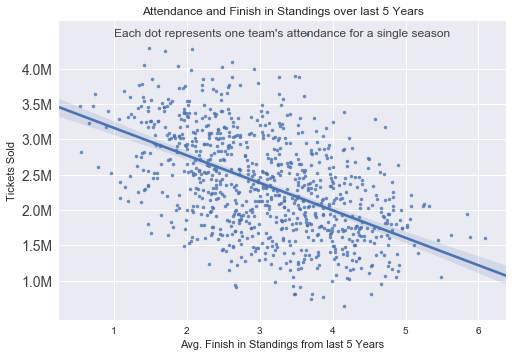

(-0.5178327594569798, 2.1463737975146773e-61)


In [17]:
mergedf['rollingrank'] = mergedf['Rank'].rolling(5).mean()
mergedf = mergedf.fillna(mergedf.mean())
x = mergedf['rollingrank'] # population of metro area where MLB team is based 
y = mergedf['attendance']

ax1=sns.regplot(x,y,data=teamdf,x_jitter=.5,marker=".")
ax1.set(title='Attendance and Finish in Standings over last 5 Years', ylabel='Tickets Sold', xlabel="Avg. Finish in Standings from last 5 Years")
ax1.set_yticks([1000000, 1500000, 2000000, 2500000,3000000,3500000,4000000])
ax1.set_yticklabels(labels=['1.0M', '1.5M', '2.0M', '2.5M', '3.0M', '3.5M','4.0M'], fontsize=14, color='#414141')
ax1.text(x=3.3, y=4500000, s="Each dot represents one team's attendance for a single season", fontsize=12, horizontalalignment='center', verticalalignment = 'center',color='#414141')
plt.show()
pval = sp.stats.pearsonr(y, x)
print(pval)

### After testing out different rolling lengths, the 5-year average of rank had the strongest correlation, -0.52. This possibly means that if a team has finished high in the standings the previous 4 years, fans are more likely to come to games. On the other end, if a team has been struggling the past 4 seasons, it may take a fanbase another year or so to realize how well the team is doing and then they start going to more games.

### Winning over the last three years looks to be a decent indicator of the current year's attendance total. Let's see which correlation is stronger. We will filter out any variables that did not look to have any significant correlation with attendance and then create a correlation matrix. 

In [18]:
corr_matrix = ['attendance','Rank','W','rollingwins','parkscore','pop','citygdp','big4teams','income','milestonextpark','Bapop',
              'abstemp','payroll']
mergedf[corr_matrix].corr()

,attendance,Rank,W,rollingwins,parkscore,pop,citygdp,big4teams,income,milestonextpark,abstemp,payroll
attendance,1.000000,-0.405478,0.499675,0.559941,0.355417,0.290747,0.301842,0.300894,0.166052,-0.085557,-0.220484,0.537384
Rank,-0.405478,1.000000,-0.783163,-0.575387,-0.017885,-0.157987,-0.165279,-0.164508,-0.101231,0.054051,0.103093,-0.258524
W,0.499675,-0.783163,1.000000,0.741573,0.067611,0.173642,0.186635,0.172722,0.128619,-0.061158,-0.096867,0.313485
rollingwins,0.559941,-0.575387,0.741573,1.000000,0.054579,0.220534,0.236068,0.215857,0.162097,-0.095875,-0.136639,0.428320
parkscore,0.355417,-0.017885,0.067611,0.054579,1.000000,0.163758,0.211962,0.205051,0.214623,-0.199930,-0.180867,0.300486
pop,0.290747,-0.157987,0.173642,0.220534,0.163758,1.000000,0.984978,0.897422,0.275348,-0.400409,-0.245135,0.322322
citygdp,0.301842,-0.165279,0.186635,0.236068,0.211962,0.984978,1.000000,0.909363,0.411030,-0.417917,-0.233804,0.336493
big4teams,0.300894,-0.164508,0.172722,0.215857,0.205051,0.897422,0.909363,1.000000,0.422677,-0.454597,-0.146609,0.316431
income,0.166052,-0.101231,0.128619,0.162097,0.214623,0.275348,0.411030,0.422677,1.000000,-0.290006,0.200018,0.173549
milestonextpark,-0.085557,0.054051,-0.061158,-0.095875,-0.199930,-0.400409,-0.417917,-0.454597,-0.290006,1.000000,0.331705,-0.134761


### If we focus on the attendance column, we can see our 'rollingwins' variables has the strongest correlation out of all variables with 0.56. We try using this rather than the single season 'W' variable which had a .50 correlation. I think the 3 year rolling win average is a better indicator for attendance because fans get used to their team winning over a few years and will go to games a year following a succesful year, even if the team might underperform the following year. 

### I am somewhat surprised to see 'payroll' (sum of players' salaries) has a stronger correlation, 0.54, with attendance than it does with winning, 0.31. I think this might be due to fans expecting a team to win when a team pays their players a lot, but sometimes those teams underperform in the win column. 

### 'Pop' (population of city), 'citygdp', 'big4teams' (number of professional sports teams in city) all have moderate  positive correlations with attendance. However, they all have strong correlations with each other, so to avoid multicolinearity, I should avoid using more than one of them in my regression model.

# Insights

## Creating a Linear Regression Model to Predict Attendance

### After a lot of trial and error here are the variables that created the most significant model for predicting MLB attendance:
#### rollingwins: average wins over last 3 years
#### payroll: how much the team is paying all their players in current year
#### abstemp: how close a city's average teamperature during baseball season is to 70 degrees
#### parkscore: a score created from three different online rankings of best and worst ballparks (0 is the worst and 1 is the best)
#### in_city_since: the first year the team played in current city
#### years_in_city: how many years the team has been in current city up to that point
#### milestonextpark: distance in miles to nearest MLB team

### An R-squared value of 0.538 means that 53.8% of the variance of attendance is explained by the variables in the model. I believe if I had a larger or more informative dataset I would be able to get that value closer to 1. 

### Overall, I am pretty happy with the results. I find it interesting that my model included three variables solely tied to the city (distance to nearest team, how close the city's weather is to 70 degrees, and parkscore). This will be important when looking at possible cities to relocate struggling MLB teams.

In [21]:
mergedf.to_csv('BASEBALL.csv', index=False)

In [ ]:
dep_var = mergedf['attendance']
ind_var = ['rollingwins','payroll','parkscore','in_city_since',
          'years_in_city','abstemp','milestonextpark']
mergedf = mergedf[ind_var]
mergedf['attendance'] = dep_var

x = mergedf.drop(['attendance'],axis=1)
x = sm.add_constant(x)
y = mergedf['attendance']
OLSmodel = sm.OLS(y,x)
OLSmodelResult = OLSmodel.fit()
OLSmodelResult.summary()

In [ ]:
mpl.rcParams['figure.figsize'] = (9,5)
ax = sns.regplot(x=OLSmodelResult.predict(x), y=mergedf.attendance, data=mergedf, marker='.')
ax.set_xlabel('Model Prediction of Attendance', size=15)
ax.set_ylabel('Actual Attendance',size=15)
plt.title("Predicted Attendance vs. Actual Attendance")

plt.show()

### Each dot in the above chart represents one MLB's attendance for a full season. The closer a dot is to the line, the better the regression model did at predicting the actual attendance for that year. 

In [ ]:
bins = 11
x = OLSmodelResult.predict(x)
y = mergedf['attendance']
plt.hist(x, bins, alpha=0.5, label='Predicted Results from Model')
plt.hist(y, bins, alpha=0.5, label='Actual Attendance Figures')
plt.legend(loc='upper right')
plt.show()

### By looking at the histogram above, we see the actual attendance figures had more variance than the model's predictions. There are more seasons with very low attendance and very high attendance than the regression model had. The large majority of the model overlaps with the actual results, which means the model can be used fairly accurately, although being somewhat conservative, to predict final season attendance totals. 

In [ ]:
print('Actual Attendance Figures')
print()
print(y.describe())

In [ ]:
print('Predicted Attendance Figures')
print()
print(x.describe())

### As expected, the standard deviation is higher for the actual results compared to the model. 

### Interpretting the coefficients of the regression model
#### For every 1 more win on average over last three years = 27,470 more tickets sold that season
#### For every 1 more million dollars in player's payroll = 9,100 more tickets sold that season
#### The best quality ballpark should expect 625,200 more tickets sold than the worst quality ballpark.
#### The longer a team has been based in a city, the more tickets they can expect to be sold. For each additional year a team is based there, they can expect 54,330 more tickets sold.
#### For every 1 degree difference from 70 for a city's average temperature during baseball season = 20,250 fewer tickets sold
#### For every 1 mile away from next MLB team = 277 more tickets sold that season

# Testing Struggling MLB Teams in Different Cities

### The ultimate goal of this project was to identify the cities that would have the most success in regards to attendance if an MLB were to relocate. I only chose to test nine cities that have recently been rumored as possible relocation cities. The regression model has Nashville, TN as the best landing spot, followed very closely by Charlotte, NC and Raleigh, NC. These cities scored the best due to their average temperatures during baseball season are very close to 70 degrees. They also scored high because the nearest MLB teams to them are between 248 and 278 miles away. 
### The Marlins were the team who had the most to gain when using their 2019 inputs (rolling wins, payroll, parkscore). If using the model, the Marlins would expect 12.4% higher attendance if they were in Nashville, even if they had a ballpark with the same poor quality (parkscore is in the fourth of all ballparks). If they moved to Nashville it would be assumed a new state-of-the-art ballpark would be waiting for them. If we assume they have at least an average parkscore in Nashville, they would expect to have 22.9% growth in attendance.
### It is worth noting these growth projections are comparing the Marlins *projected model* attendance, which is about *78% higher* than their actual attendance figures from 2019. The model does not do a great job at predicting extremely high and low attendance figures. 
### If we use the model and compare projected Nashville attendance to the Marlins actual 2019 figures, the growth is much higher. 105% more tickets sold with the same quality ballpark, and 124% if Nashville was able to secure a ballpark that has an average score.

In [ ]:
print('Projections with same Ballpark Score')

display(Image(filename="samepark.jpg"))
print('Projections with new (Average) Ballpark Score')

display(Image(filename="newpark.jpg"))